## Neural network 구현
1. 학습 목적 : 기본적인 딥러닝 파이프라인을 처음부터 끝까지 구현하는 것
2. 학습 목표
    - MLP 를 구성하는 weight, bias, activation function 에 대해 이해한 바를 데이터셋(MNIST)에 맞추어 하나의 클래스로 구현한다.
    - 대표적인 Loss function 인 MSC 와 CE 를 구현하여 MNIST 데이터셋에 대해서 결과가 어떻게 다른지 이해한다.
    - SGD 및 Backpropagation 알고리즘에 대한 이해를 바탕으로 MLP 모델의 파라미터를 업데이터하는 과정을 구현한다.

### 목차
0. 환경설정
1. MNIST 데이터셋 불러오기
    - 데이터셋 개요
    - 다운로드 및 압축 해제
    - 데이터셋 전처리

2. MLP 모델 구성
    - 활성화 함수 구현
    - MLP 레이어 구현
    - 손실 함수 구현
    - MLP 모델 구현

3. 모델 학습
    - 모델 학습 전 준비 (하이퍼 파라미터 설정 등)
    - 모델 학습하기
4. 결과 시각화
    - 학습 곡선
    - 결과 데이터 시각화

### 환경설정

In [1]:
## 모델 학습 및 결과 시각화
import numpy as np                      # 행렬 연산을 위한 라이브러리 - 데이터셋 불러오기, 모델 학습 class 구성
import matplotlib.pyplot as plt         # 시각화 라이브러리 - 학습결과 시각화
from tqdm.notebook import tqdm          # for 문의 진행 상태 표시 라이브러리 - 학습 시간 및 진행 상태 확인.

## 유틸리티 라이브러리
import os                               # 파일 경로를 확인하는데 사용하는 라이브러리
import random                           # 데이터를 랜덤하게 섞는데 사용하는 라이브러리
import platform                         # 현재 사용하는 운영체제를 확인하는데 사용하는 라이브러리
import warnings                         # 경고 메세지를 무시하거나 숨기는데 사용하는 라이브러리
# 중요하지 않은 에러 무시
warnings.filterwarnings(action='ignore')

## MNIST 데이터셋을 불러오는데 사용하는 라이브러리
import gzip                             # 압축된 파일을 읽는데 사용하는 라이브러리
from urllib.request import urlretrieve  # url로 부터 데이터를 다운로드하는데 사용하는 라이브러리.

In [2]:
# 재현성을 위한 시드 고정
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [3]:
# 현재 os 및 파이썬 버전 확인
print(f'Current OS: {platform.system()}')
print(f'Python version: {platform.python_version()}')

Current OS: Windows
Python version: 3.11.5


In [4]:
# 라이브러리 버전 확인
from importlib.metadata import version
print("numpy version : {}".format(version("numpy")))
print("matplotlib version : {}".format(version("matplotlib")))

numpy version : 1.24.3
matplotlib version : 3.7.2


In [5]:
# matplotlib 해상도 높이기
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

---

### 1. 데이터셋 불러오기

#### 1-1 데이터셋 개요

<div align="center">
<img src="https://upload.wikimedia.org/wikipedia/commons/f/f7/MnistExamplesModified.png" alt="MNIST Test Data Samples">
</div>

* 데이터셋 : MNIST(Modified National Institute of Standards and Technology) Database

- 데이터셋 구성
    - 입력(이미지): 0~9 까지의 숫자 중 하나에 속하는 28px * 28px 의 흑백 이미지
    - 출력(숫자): 주어진 이미지에 대응되는 숫자 (0~9)
- 데이터 샘플 수
    - 학습 데이터: 60,000 개
    - 테스트 데이터: 10,000 개

* 데이터셋 저작권: [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/)

#### 1-2 MNIST 데이터셋 다운로드 및 압축 해제

In [6]:
# MNIST를 다운받을 경로
url = 'http://yann.lecun.com/exdb/mnist/'

#MNIST 를 저장할 디렉토리
dataset_dir = os.path.join(os.getcwd(), 'data')

# 해당 경로가 없을 시 디렉토리 새로 생성
os.makedirs(dataset_dir, exist_ok=True)

# MNIST 데이터셋의 파일명
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

# 해당 경로에 존재하지 않는 파일 모두 다운로드
for filename in key_file.values():
    if filename not in os.listdir(dataset_dir):
        urlretrieve(url + filename, os.path.join(dataset_dir, filename))
        print("Download %s to %s" % (filename, dataset_dir))


#### 1-3 데이터셋 전처리 
목적 : numpy 에서 사용이 가능하도록

- `(n, 28, 28)` 이 아닌 `(n, 784)` 크기가 되도록 변환
- 기존 0~255 사이의 정수롤 표현된 흑백 이미지의 픽셀 값을 0과 1사이의 실수값이 되도록 `정규화`

##### Image data 특징

In [7]:
with gzip.open(os.path.join(dataset_dir, key_file['train_img'])) as f:
    pixels = np.frombuffer(f.read(), 'B')

print(pixels.shape)
print(pixels[:16])

(47040016,)
[  0   0   8   3   0   0 234  96   0   0   0  28   0   0   0  28]


첫 16 바이트는 magic_number, n_imgs, n_row, n_cols 의 정보를 의미한다:

- `magic_number` (0x00000803)
    - 데이터 파일의 타입을 나타내기 위해 사용됨.
    - `08`: 이미지 데이터
    - `03`: 데이터 타입이 3차원 배열 (이미지 수, 행, 열)
- `n_imgs`
    - `234 == 0xEA`, `96 == 60`
    - `EA60` => 60,000

In [8]:
def _images(path):
    '''
    MNIST 데이터셋 이미지를 Numpy Array 로 변환하여 불러오기
    '''
    # gzip 파일을 열고, 이미지를 읽어서 1차원 배월로 반환
    with gzip.open(path) as f:
        # 첫 16 바이트는 magic_number, n_imgs, n_rows, n_cols 의 정보이므로 무시
        pixels = np.frombuffer(f.read(), 'B', offset=16)

    # 28*28 = 784 이므로 784 차원으로 reshape 해준 뒤, 0~255 값을 0~1 로 정규화.
    return pixels.reshape(-1, 28*28).astype('float32') / 255

In [9]:
# _image 함수를 사용하여 다운받은 학습/데이터 이미지를 numpy 행렬로 변환 및 전처리
X_train = _images(os.path.join(dataset_dir, key_file['train_img']))
X_test = _images(os.path.join(dataset_dir, key_file['test_img']))

##### Label 데이터 특징

In [10]:
with gzip.open(os.path.join(dataset_dir, key_file['train_label'])) as f:
    pixels = np.frombuffer(f.read(), 'B')

print(pixels.shape)
print(pixels[:8])

(60008,)
[  0   0   8   1   0   0 234  96]


- 첫 8 바이트는 magic_number, n_labels 의 정보

In [12]:
def _onehot(integer_labels):
    '''
    0`9 의 라벨 데이터를 one-hot encoding 하기
    '''
    n_rows = len(integer_labels)        # 라벨 데이터의 길이
    n_cols = integer_labels.max() + 1   # 라벨 데이터의 최댓값 + 1(0포함)

    # 0으로 채워진 (n_rows, n_cols) 크기의 행렬 생성
    # 0 과 1로 이루어진 array 이므로 가장 크기가 작은 데이터타입 사용
    onehot = np.zeros((n_rows, n_cols), dtype='uint8')
    # one-hot 행렬의 각 행에 해당하는 라벨을 1로 변경
    onehot[np.arange(n_rows), integer_labels] = 1

    return onehot

def _label(path):
    '''
    MNIST 데이터셋 라벨을 Numpy Array 로 변환하여 불러오기
    '''
    # gzip 파일을 열고, 라벨 데이터를 불러온 뒤, integer로 변환
    with gzip.open(path) as f:
        integer_labels = np.frombuffer(f.read(), 'B', offset=8)
    
    return _onehot(integer_labels)

In [13]:
# _label 함수를 사용하여 학습/테스트 라벨을 numpy 행렬로 변환 및 전처리
y_train = _label(os.path.join(dataset_dir, key_file['train_label']))
y_test = _label(os.path.join(dataset_dir, key_file['test_label']))

In [14]:
# 최종 데이터셋의 형태 확인
print('X_train의 형태 : {}'.format(X_train.shape))
print('y_train의 형태 : {}'.format(y_train.shape))
print('X_test의 형태  : {}'.format(X_test.shape))
print('y_test의 형태  : {}'.format(y_test.shape))

X_train의 형태 : (60000, 784)
y_train의 형태 : (60000, 10)
X_test의 형태  : (10000, 784)
y_test의 형태  : (10000, 10)


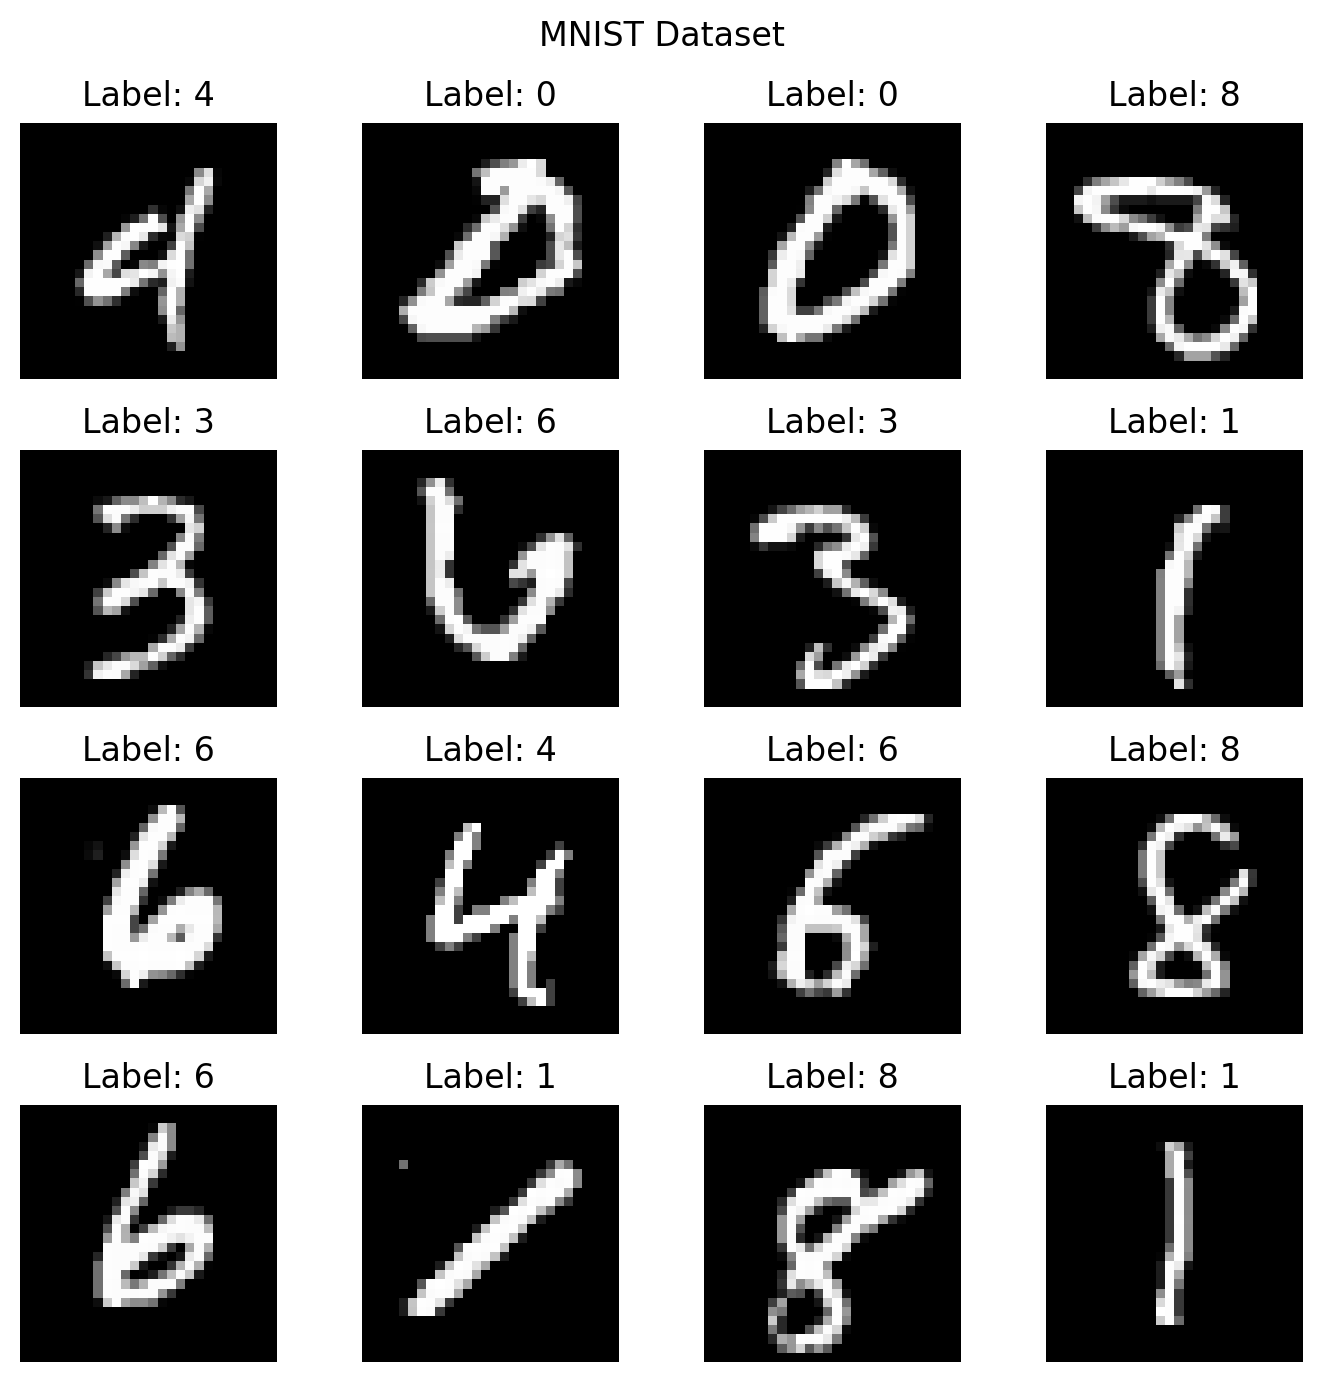

In [15]:
# 학습 데이터 내의 임의의 16개 샘플 살펴보기

# 7x7 사이즈의 figure 생성
plt.figure(figsize=(7,7))
# 16개의 랜덤한 정수 생성
random_indices = np.random.randint(0, len(X_train), size=16)

# 16 개의 랜덤한 정수에 해당하는 이미지를 4x4 그리드에 하나씩 출력
for n, idx in enumerate(random_indices, start=1):
    '''
    4x4 그리드의 n 번째 위치를 지정
    해당 위치에 그레이스케일 이미지를 출력하고, 타이틀로는 라벨 값을 출력
    x,y 축이 필요하지 않으므로 눈금 출력 생략
    '''
    plt.subplot(4,4,n)
    plt.imshow(X_train[idx].reshape(28,28), cmap='gray')
    plt.title(f'Label: {y_train[idx].argmax()}')
    plt.axis('off')
    
plt.suptitle('MNIST Dataset')
plt.tight_layout()
plt.show()

---

#### 2-1. 활성화 함수 구현
- 시그모이드 함수 및 도함수의 수식
- 시그모이드 레이어 구현


##### 📝 <font color='orange'><b>[ 설명 ]</b></font> 시그모이드 함수 및 도함수의 수식

$$ f = \frac{1}{1 + e^{-x}}$$

$$ \frac{\partial f}{\partial x} = \left(1.0 - f(x) \right) f(x) $$


In [16]:
class Sigmoid():
    '''
    시그모이드 레이어 (시그모이드 함수의 클래스)
    '''
    def __init__(self):
        self.out = None # [n x 해당 layer 의 neuron 개수]

    def __str__(self) -> str:
        return 'Out of Activation function -> ' + str(self.out.shape)

    def forward(self, x):
        '''
        시그모이드 레이어의 순전파(forward propagation)
        결과를 attribute 로 저장 및 리턴
        '''
        self.out = self.sigmoid(x)
        return self.out
    
    def backward(self, dout):
        '''
        시그모이드 레이어의 역전파(backward propagation)
        역전파의 경우 그래디언트 값을 리턴
        dout: upstream
        '''
        dx = dout * (1.0 - self.out) * self.out
        return dx

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

#### 2-2 MLP 레이어 구현
- fully-connected layer
- linear layer
- dense layer

In [17]:
class FCLayer():
    '''
    완전 연결 레이어 (Fully-Connected Layer, FC Layer)
    '''
    def __init__(self, input_size, output_size, weight_init_std=0.01) -> None:
        '''
        가중치와 편향 초기화
        input_size: 입력 데이터의 차원 수
        output_size: 출력 데이터의 차원 수
        weight_init_std: 가중치 초기화 시 사용하는 표준 편차
        '''
        # 가중치는 정규분포를 따르는 난수로 초기화
        self.W = np.random.randn(input_size, output_size)
        # 편향도 정규분포를 따르는 난수로 초기화
        self.b = np.random.randn(output_size)

        # 역전파 계산을 위한 입력 데이터 저장
        self.x = None
        # 모델 학습을 위해 가중치와 편향의 그래디언트 저장
        self.dW = None
        self.db = None

    def __str__(self) -> str:
        return f'Out of FCLayer -> {(self.x.shape[0], self.W.shape[1])}'


    def forward(self, x):
        self.x = x
        # y = Wx + b
        # [1 x input_size] * [input_size x output_size]
        out = np.dot(x, self.W) + self.b

        return out
    
    def backward(self, dout):
        """역전파(backpropagation)
        Gradient for Input, Weight, bias
        """
        # 1 == batch_szie

        # dy/dx = W -> dx = dy * W
        # [1 x output_size] * [output_size x input_size]
        # -> [1 x input_size]
        dx = np.dot(dout, self.W.T) 
        # dy/dW = x -> dW = x * dy
        # [input_size x 1] * [1 x output_size]
        # -> [input_size x output_size]
        self.dW = np.dot(self.x.T, dout)
        # dy/db = 1 -> db = dy * 1
        # [1 x output_size]
        # 모든 입력에 같은 bias를 더함
        # -> sum? 해당 bias 가 모든 batch 에 주는 영향을 합산
        self.db = np.sum(dout, axis=0)
        print(dout.shape)
        print(dout)
        print(self.db.shape)
        print(self.db)

        return dx

In [18]:
x = np.random.randn(5, 2)
y = np.random.randn(5, 3)
print('x =\n', x)

fc_layer = FCLayer(2, 3)
fc_layer.forward(x)
fc_layer.backward(y)

x =
 [[-0.46947439  0.54256004]
 [-0.46341769 -0.46572975]
 [ 0.24196227 -1.91328024]
 [-1.72491783 -0.56228753]
 [-1.01283112  0.31424733]]
(5, 3)
[[-0.90802408 -1.4123037   1.46564877]
 [-0.2257763   0.0675282  -1.42474819]
 [-0.54438272  0.11092259 -1.15099358]
 [ 0.37569802 -0.60063869 -0.29169375]
 [-0.60170661  1.85227818 -0.01349722]]
(3,)
[-1.90419169  0.01778659 -1.41528397]


array([[-1.99058423,  0.63134195],
       [ 2.03374582,  1.71284121],
       [ 2.07222157,  1.19766019],
       [-0.53531974,  1.6429469 ],
       [ 2.17649166, -3.737602  ]])

In [20]:
# FCLayer 레이어가 임의의 입출력 데이터에 대해 잘 작동하는지 테스트

x = np.random.randn(5, 2)
y = np.random.randn(5, 3)
print('x =\n', x)

fc_layer = FCLayer(2, 3)
print('\nfc_layer.forward(x) =\n', fc_layer.forward(x))
print('\nfc_layer.backward(y) =\n', fc_layer.backward(y))

x =
 [[-0.46947439  0.54256004]
 [-0.46341769 -0.46572975]
 [ 0.24196227 -1.91328024]
 [-1.72491783 -0.56228753]
 [-1.01283112  0.31424733]]

fc_layer.forward(x) =
 [[ 0.80675047 -0.7109359   0.02390242]
 [ 0.5897492   1.2699614   1.35570459]
 [-0.45867949  4.68688955  2.41716231]
 [ 1.90388428  0.42154227  3.02404572]
 [ 1.33377861 -0.71045361  0.9904978 ]]

fc_layer.backward(y) =
 [[-1.99058423  0.63134195]
 [ 2.03374582  1.71284121]
 [ 2.07222157  1.19766019]
 [-0.53531974  1.6429469 ]
 [ 2.17649166 -3.737602  ]]


#### 2-3. 손실함수 구현

#### 📝 <font color='orange'><b>[ 설명 ]</b></font> MSE 손실 함수 및 도함수의 수식
$$
L_{MSE}(y,\hat{y}) = \frac{1}{n}\sum_{i=1}^n \left(y_i - \hat{y}_i \right)^2
$$

$$
\frac{dL}{d\hat y} = \frac{2}{n}\sum_{i=1}^n \left(\hat{y}_i - y\right)
$$

#### 📝 <font color='orange'><b>[ 설명 ]</b></font> 교차엔트로피(CE) 손실 함수 및 도함수의 수식
$$
L(y,\hat{y}) = \frac{-1}{n}\sum_{i=1}^n y_i\log(\hat{y}_i)+(1-y_i)(\log(1-\hat{y}_i)
$$

$$
\frac{dL}{d\hat y} = \frac{-1}{n}\left(\frac{y_i}{\hat{y}_i} - \frac{1-y_i}{1 - \hat{y}_i}\right) = \frac{\hat{y}_i-y_i}{n(1-\hat{y}_i)\hat{y}_i}
$$

In [17]:
class MSELoss():
    '''
    Mean Squared Error Lostt
    '''
    def __init__(self) -> None:
        self.loss = None    # 손실 함수 값. 역전파 계산을 위해 인스턴스 내에 저장됨.
        self.y = None       # 추론값 [n x output_size]
        self.t = None       # 실제값 (target) [n x output_size]

    def forward(self, y, t):
        self.y = y
        self.t = t
        self.loss = np.mean((t-y)**2)
        return self.loss
    
    def backward(self, dout=1):
        dx = dout * (self.y - self.t) * 2 / self.t.shape[0]
        return dx

In [18]:
class CrossEntropyLoss():
    def __init__(self) -> None:
        self.loss = None    # 손실 함수 값. 역전파 계산을 위해 인스턴스 내에 저장됨.
        self.y = None       # 추론값 [n x output_size]
        self.t = None       # 실제값 (target) [n x output_size]

    def forward(self, y, t):
        self.y = y
        self.t = t
        self.loss = - np.sum(t * np.log(y + 1e-7) + (1 - t) * np.log(1 - y + 1e-7)) / len(y)
        return self.loss
    
    def backward(self, dout = 1):
        dx = dout * (self.y - self.t) / (self.t.shape[0] * (1-self.y) * self.y + 1e-7)
        return dx

#### 2-4. MLP 모델 구현

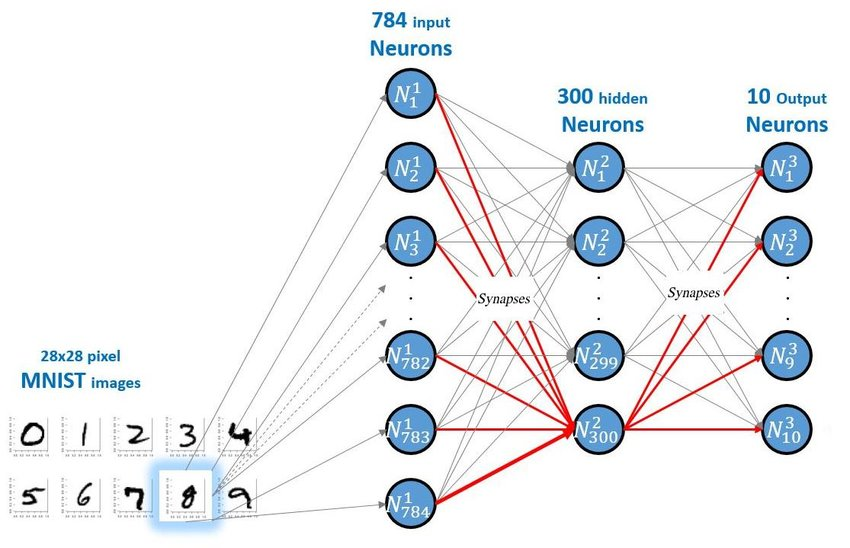

In [19]:
class MLP():
    '''
    다층 퍼셉트론 모델
    '''
    def __init__(self, input_size, hidden_size_list, output_size, loss_type="MSE") -> None:
        '''
        input_size: 입력 데이터의 차원 수
        hidden_size_list: 은닉층 차원 수의 리스트 (e.g. [100, 100, 100])
        output_size: 출력 데이터의 차원 수
        loss_type: 손실 함수의 종류 ('MSE' or 'CrossEntropy')
        '''
        
        self.input_size = input_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.output_size = output_size
        self.loss_type = loss_type

        # 레이어 쌓기 FCLayer -> Sigmoid -> ... -> FCLayer -> Sigmoid
        # 입력층
        self.layers = [
            FCLayer(input_size, hidden_size_list[0]),
            Sigmoid()
        ]
        # 은닉층
        for idx in range(1, self.hidden_layer_num):
            self.layers.append(FCLayer(hidden_size_list[idx-1], hidden_size_list[idx]))
            self.layers.append(Sigmoid())
        # 출력층
        self.layers.append(FCLayer(hidden_size_list[-1], output_size))
        self.layers.append(Sigmoid())

        # [손실 함수 레이어] 인자로 받은 `loss_type`에 맞게 정하기
        if self.loss_type == 'MSE':
            self.loss_layer = MSELoss()
        elif self.loss_type == 'CrossEntropy':
            self.loss_layer = CrossEntropyLoss()
        else:
            self.loss_layer = None

        self.loss = None

    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def forward(self, x, t):
        y = self.predict(x)
        self.loss = self.loss_layer.forward(y, t)
        return self.loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout


In [20]:
x = np.random.randn(5, 2)
y = np.random.randn(5, 1)
mlp = MLP(input_size=2, hidden_size_list=[10, 5], output_size=1, loss_type='MSE')

for layer in mlp.layers:
    x = layer.forward(x)
    print(layer)

print(f'Value of Loss function -> {mlp.loss_layer.forward(x, y)}')

Out of FCLayer -> (5, 10)
Out of Activation function -> (5, 10)
Out of FCLayer -> (5, 5)
Out of Activation function -> (5, 5)
Out of FCLayer -> (5, 1)
Out of Activation function -> (5, 1)
Value of Loss function -> 1.8913201198309284


In [21]:
# 임의의 입출력 데이터와 하이퍼파라미터에 대해 MLP 모델이 에러 없이 작동하는지 테스트

x = np.random.randn(5, 2)
y = np.random.randn(5, 1)
print('x =\n', x)

mlp = MLP(input_size=2, hidden_size_list=[10, 5], output_size=1, loss_type='MSE')
print('\nmlp.predict(x) =\n', mlp.predict(x))
print('\nmlp.forward(x, y) =\n', mlp.forward(x, y))
print('\nmlp.backward() =\n', mlp.backward())

x =
 [[-0.19236096  0.30154734]
 [-0.03471177 -1.16867804]
 [ 1.14282281  0.75193303]
 [ 0.79103195 -0.90938745]
 [ 1.40279431 -1.40185106]]

mlp.predict(x) =
 [[0.3097185 ]
 [0.31391276]
 [0.28525971]
 [0.30046046]
 [0.29437335]]

mlp.forward(x, y) =
 1.2030121685851318

mlp.backward() =
 [[ 0.0016435   0.00025413]
 [ 0.00739838  0.00268657]
 [-0.00855585 -0.00184929]
 [-0.00641222 -0.00340778]
 [-0.00151353 -0.00099983]]


---

#### 모델 학습하기

`💡 목차 개요 : 모델을 선언하기 위한 하이퍼파라미터 세팅부터 SGD를 통해 모델을 학습하는 과정 구현`

##### 3-1. 모델 학습 전 준비

- 정확도 함수 정의하기
- 하이퍼파라미터 설정하기
- 모델 생성하기

In [22]:
# one-hot 인코딩이 되어있는 값을 다시 라벨로 바꾸어 비교
def accuracy(y, t):
    y = np.argmax(y, axis=1)
    t = np.argmax(t, axis=1)
    return np.sum(y==t) / float(len(t))

- MSE 손실 함수는 vanishing gradient문제가 생길 수 있으므로 **CE보다 더 큰 값의 학습률을 설정**
- MNIST 데이터셋의 경우 학습이 쉬운 데이터셋이기에 본 실습에서는 빠른 학습을 위해 큰 값으로 정하였으나, <br>**일반적으로 학습률은 소수점 단위(0.01 ~ 0.000001)로 설정되는 매우 작은 값**이다.

In [23]:
# 하이퍼 파라미터 설정
n_input = 784
n_hidden = (64,16,)
n_output = 10

# 학습에 필요한 하이퍼파라미터
batch_size = 128
n_epochs = 30
print_every = 1
learning_rate_mse = 3
learning_rate_ce = 0.5



In [24]:
# MSE 손실 함수를 사용하는 MLP 모델
mlp_mse = MLP(n_input, n_hidden, n_output, loss_type='MSE')

# Cross Entropy 손실 함수를 사용하는 MLP 모델
mlp_ce = MLP(n_input, n_hidden, n_output, loss_type='CrossEntropy')

In [25]:
##### 3-2. 모델 학습하기

In [26]:
def training(model, learning_rate, X_train, y_train, X_test, y_test):
    training_errors, training_accs = [], [] # 학습 손실 및 정확도
    test_errors, test_accs = [], []         # 테스트 손실 및 정확도

    # n_epochs 만큼 학습
    for epoch in tqdm(range(n_epochs)):
        idx = np.random.permutation(X_train.shape[0])
        X_train = X_train[idx]
        y_train = y_train[idx]

        # 미니배치 학습
        # i+batch_size가 X_train의 크기를 초과한다면, 파이썬의 슬라이싱 동작 방식에 따라 자동으로 X_train의 끝까지만 데이터를 선택됨.
        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # forward propagation
            model.forward(X_batch, y_batch)

            # backward propagation
            model.backward()

            # 모델 파라미터 업데이터 (경사하강법, Gradient Descent)
            for layer in model.layers:
                if isinstance(layer, FCLayer):
                    layer.W -= learning_rate * layer.dW
                    layer.b -= learning_rate * layer.db

        # 학습 과정 출력 : print_every의 배수에 해당할 때마다 출력
        if (epoch+1) % print_every == 0:
            # 모든 학습 데이터에 대한 손실과 정확도 계산
            model.forward(X_train, y_train)
            training_errors.append(model.loss)
            training_accs.append(accuracy(model.predict(X_train), y_train))

            # 모든 테스트 데이터에 대한 손실과 정확도 계산
            model.forward(X_test, y_test)
            test_errors.append(model.loss)
            test_accs.append(accuracy(model.predict(X_test), y_test))

            # 학습 과정 출력
            print('[Epoch {}/{}] Training Loss = {:.4f} / Training Acc = {:.2f}% /'
                  'Test Loss = {:.4f} / Test Acc = {:.2f}%'.format(
                      epoch+1, n_epochs,
                      training_errors[-1], training_accs[-1]*100,
                      test_errors[-1], test_accs[-1]*100))
            
    return np.asarray([training_errors, test_errors, training_accs, test_accs])

In [27]:
# MSE 손실 함수를 사용하는 모델 학습
training_result_mse = training(mlp_mse, learning_rate_mse, X_train, y_train, X_test, y_test)

  0%|          | 0/30 [00:00<?, ?it/s]

[Epoch 1/30] Training Loss = 0.0261 / Training Acc = 83.90% /Test Loss = 0.0255 / Test Acc = 84.24%
[Epoch 2/30] Training Loss = 0.0180 / Training Acc = 88.74% /Test Loss = 0.0179 / Test Acc = 88.83%
[Epoch 3/30] Training Loss = 0.0148 / Training Acc = 90.77% /Test Loss = 0.0152 / Test Acc = 90.21%
[Epoch 4/30] Training Loss = 0.0130 / Training Acc = 91.89% /Test Loss = 0.0138 / Test Acc = 91.15%
[Epoch 5/30] Training Loss = 0.0113 / Training Acc = 92.92% /Test Loss = 0.0124 / Test Acc = 92.15%
[Epoch 6/30] Training Loss = 0.0105 / Training Acc = 93.52% /Test Loss = 0.0117 / Test Acc = 92.40%
[Epoch 7/30] Training Loss = 0.0098 / Training Acc = 94.02% /Test Loss = 0.0112 / Test Acc = 92.98%
[Epoch 8/30] Training Loss = 0.0091 / Training Acc = 94.45% /Test Loss = 0.0107 / Test Acc = 93.28%
[Epoch 9/30] Training Loss = 0.0087 / Training Acc = 94.70% /Test Loss = 0.0105 / Test Acc = 93.31%
[Epoch 10/30] Training Loss = 0.0082 / Training Acc = 95.02% /Test Loss = 0.0101 / Test Acc = 93.67%

In [28]:
# Cross Entropy 손실 함수를 사용하는 모델 학습
training_result_ce = training(mlp_ce, learning_rate_ce, X_train, y_train, X_test, y_test)

  0%|          | 0/30 [00:00<?, ?it/s]

[Epoch 1/30] Training Loss = 1.3601 / Training Acc = 76.65% /Test Loss = 1.3372 / Test Acc = 77.01%
[Epoch 2/30] Training Loss = 0.9741 / Training Acc = 84.54% /Test Loss = 0.9601 / Test Acc = 84.68%
[Epoch 3/30] Training Loss = 0.7910 / Training Acc = 87.72% /Test Loss = 0.7916 / Test Acc = 87.45%
[Epoch 4/30] Training Loss = 0.6951 / Training Acc = 89.19% /Test Loss = 0.7003 / Test Acc = 88.94%
[Epoch 5/30] Training Loss = 0.6140 / Training Acc = 90.49% /Test Loss = 0.6316 / Test Acc = 90.04%
[Epoch 6/30] Training Loss = 0.5631 / Training Acc = 91.20% /Test Loss = 0.5895 / Test Acc = 90.47%
[Epoch 7/30] Training Loss = 0.5249 / Training Acc = 91.93% /Test Loss = 0.5560 / Test Acc = 91.28%
[Epoch 8/30] Training Loss = 0.4932 / Training Acc = 92.42% /Test Loss = 0.5350 / Test Acc = 91.71%
[Epoch 9/30] Training Loss = 0.4655 / Training Acc = 92.83% /Test Loss = 0.5149 / Test Acc = 91.95%
[Epoch 10/30] Training Loss = 0.4430 / Training Acc = 93.20% /Test Loss = 0.5019 / Test Acc = 92.21%

---

#### 4. 결과 시각화하기

##### 학습 곡선 그리기 - MSE


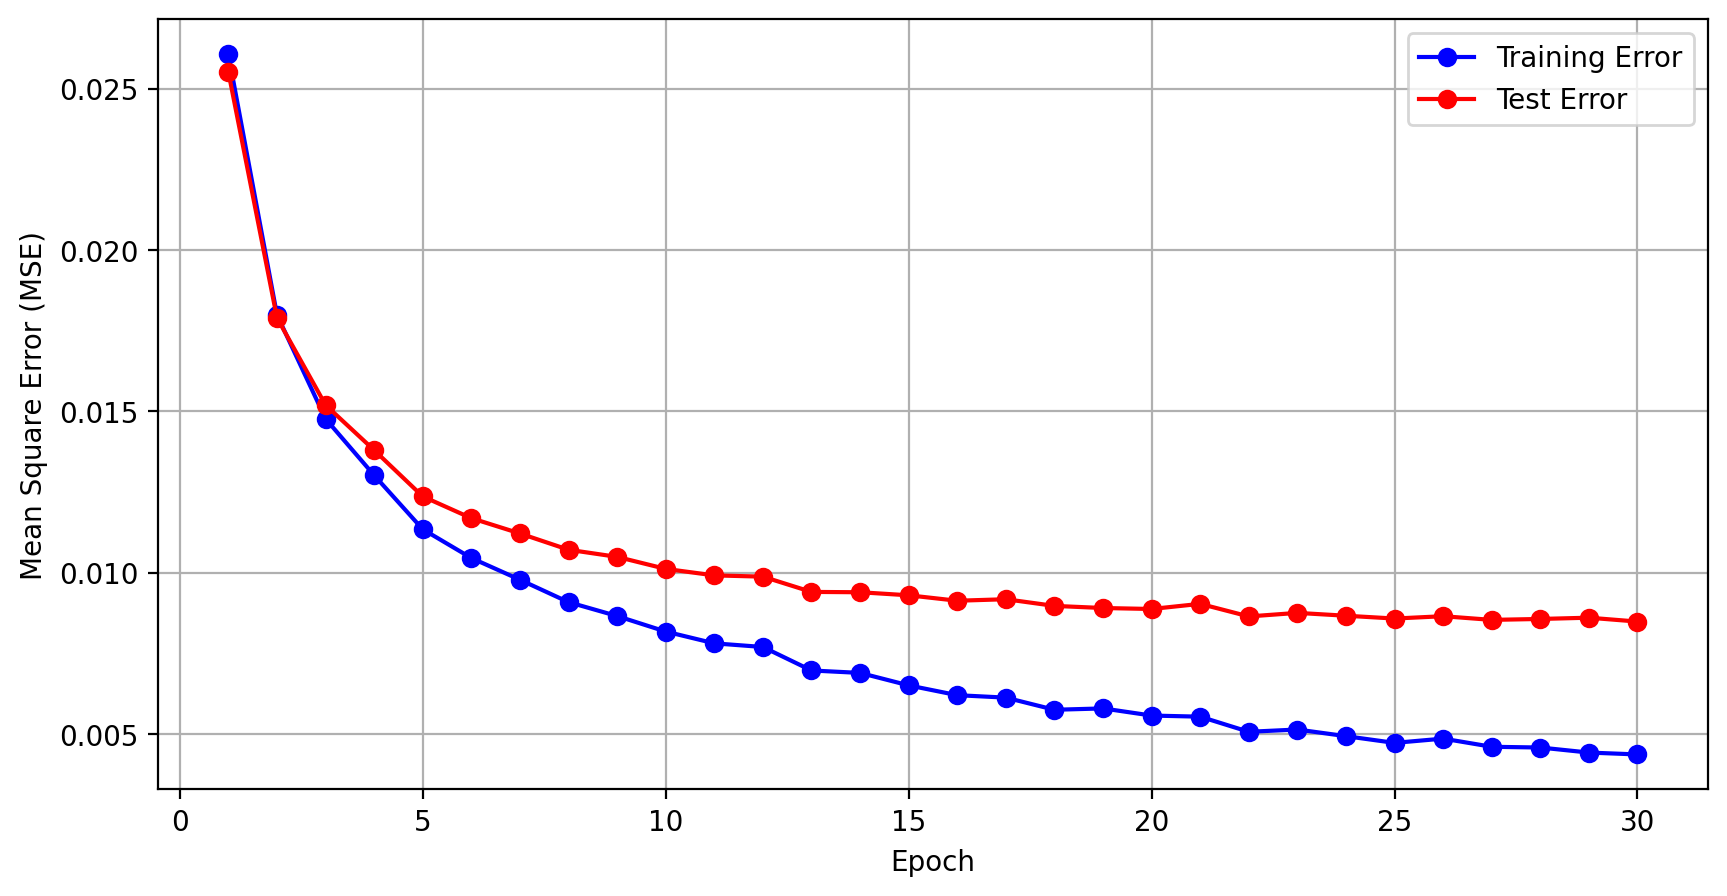

In [29]:
plt.figure(figsize=(10,5))
plt.plot(range(1, n_epochs+1), training_result_mse[0], 'bo-', label='Training Error')
plt.plot(range(1, n_epochs+1), training_result_mse[1], 'ro-', label='Test Error')
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error (MSE)')
plt.grid(True)
plt.legend()
plt.show()

##### 학습 곡선 그리기 - CE


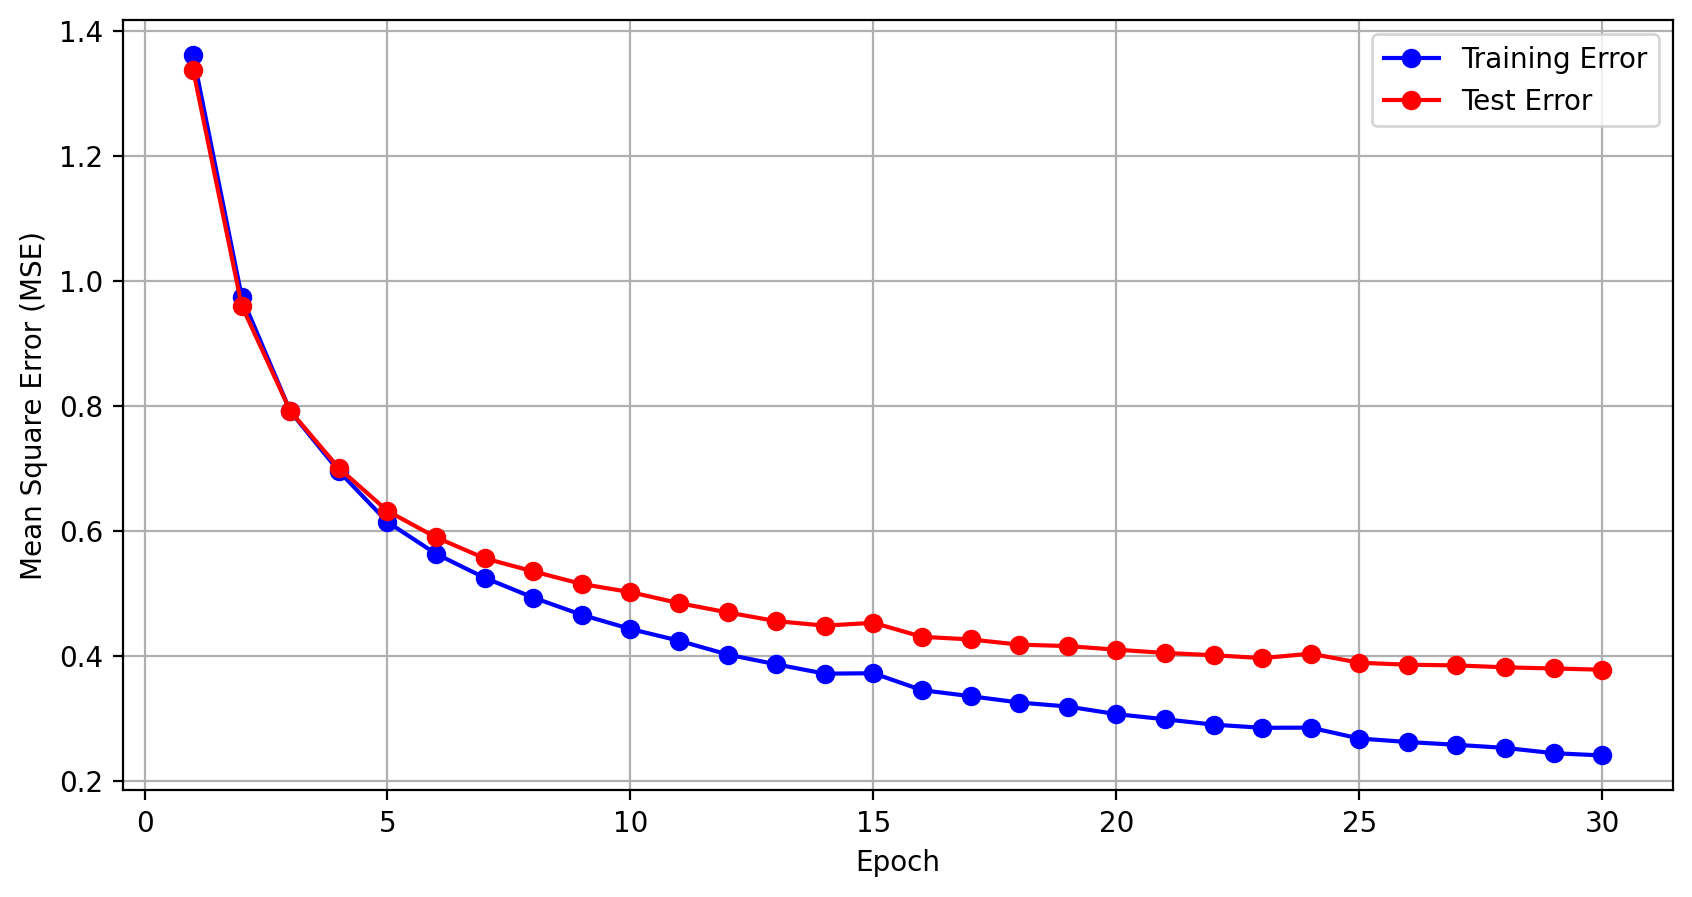

In [30]:
plt.figure(figsize=(10,5))
plt.plot(range(1, n_epochs+1), training_result_ce[0], 'bo-', label='Training Error')
plt.plot(range(1, n_epochs+1), training_result_ce[1], 'ro-', label='Test Error')
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error (MSE)')
plt.grid(True)
plt.legend()
plt.show()

##### 학습 곡선 그리기 - 정확도

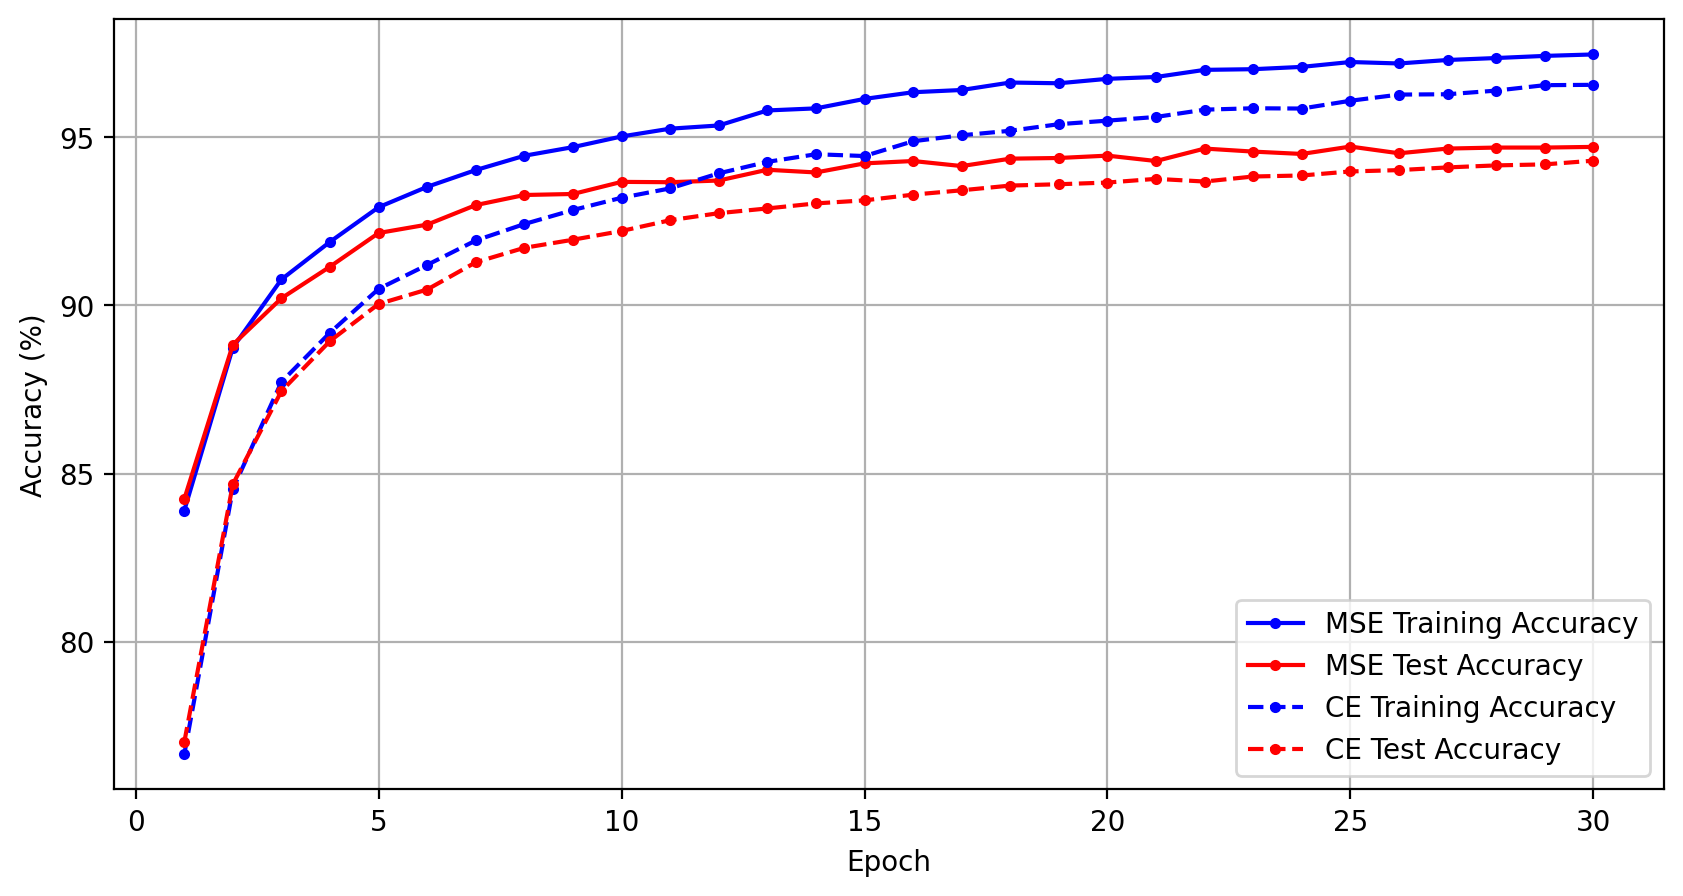

In [31]:
# 학습 및 테스트 정확도 시각화하기
plt.figure(figsize=(10, 5))
plt.plot(range(1,n_epochs+1), training_result_mse[2]*100, 'b.-', label='MSE Training Accuracy')
plt.plot(range(1,n_epochs+1), training_result_mse[3]*100, 'r.-', label='MSE Test Accuracy')
plt.plot(range(1,n_epochs+1), training_result_ce[2]*100, 'b.--', label='CE Training Accuracy')
plt.plot(range(1,n_epochs+1), training_result_ce[3]*100, 'r.--', label='CE Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()
plt.show()

##### 정답과 다르게 예측한 25개 샘플 시각화하기 -> `정성평가`

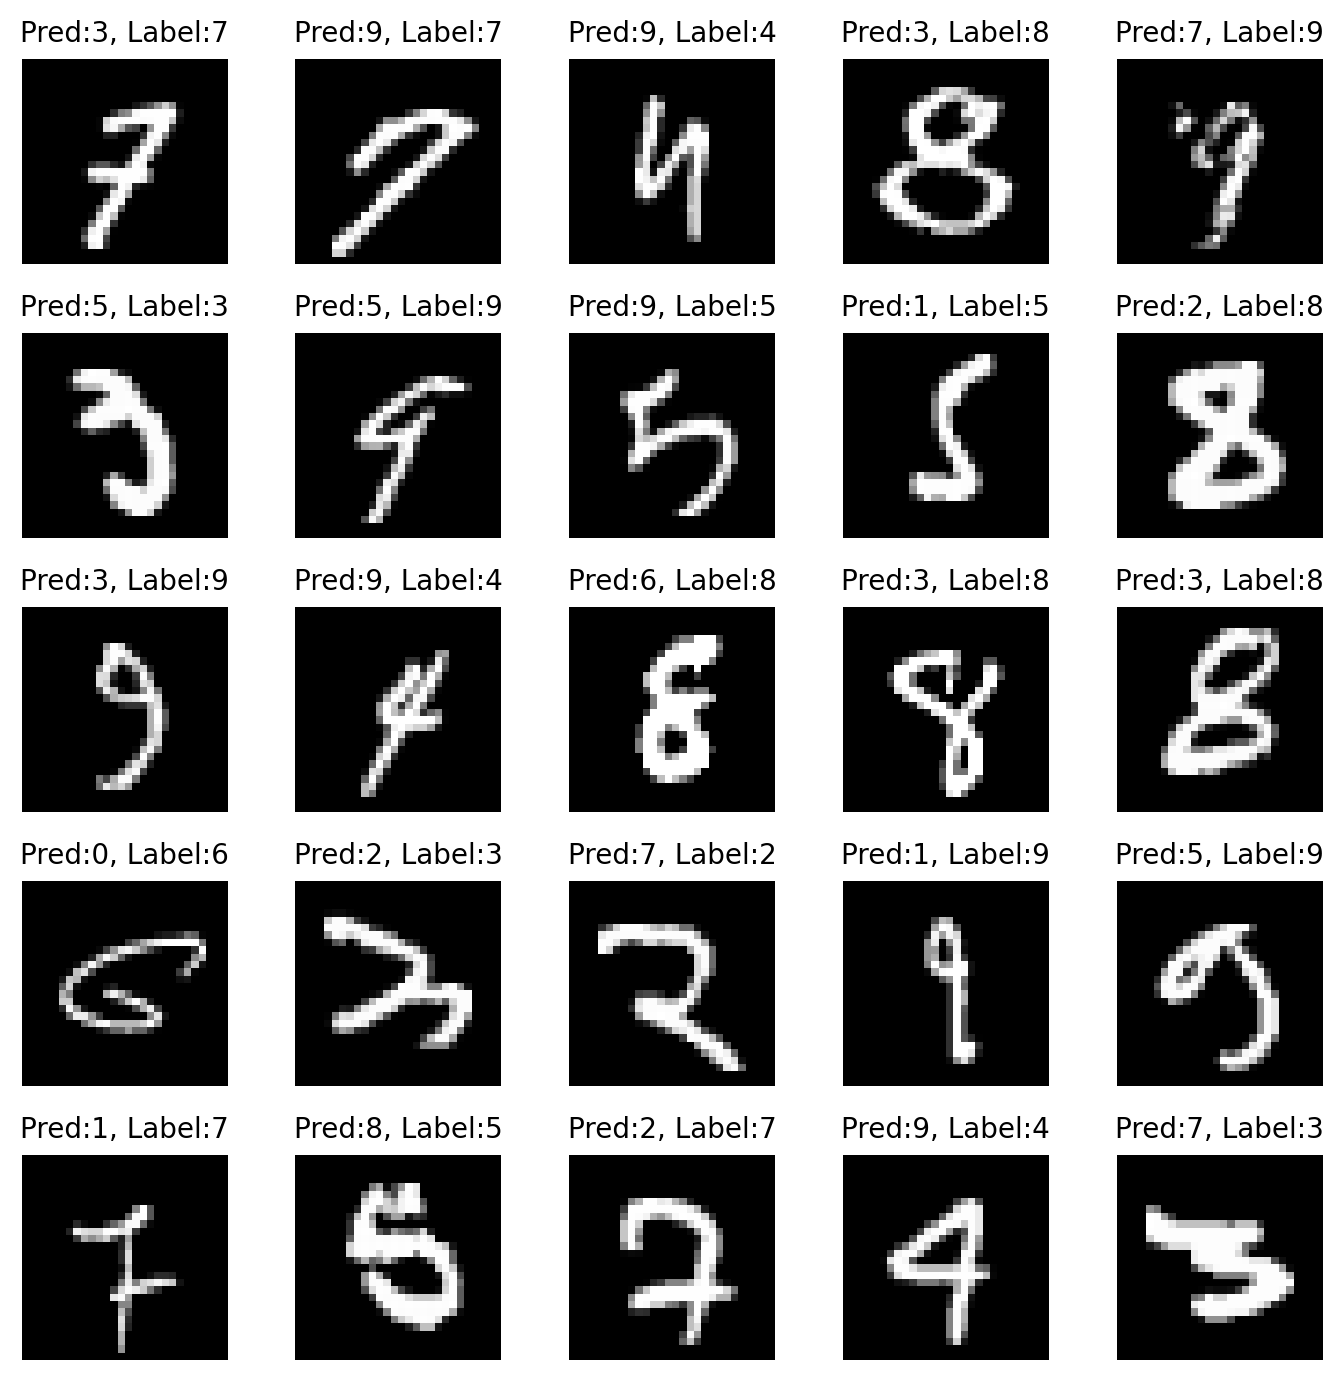

In [33]:
n_sample = 25

pred_result = np.argmax(mlp_mse.predict(X_test), axis=1)
wrong_indices = np.where(pred_result != np.argmax(y_test, axis=1))[0]
sample_indices = np.random.choice(wrong_indices, n_sample, replace=False)
sample_images = X_test[sample_indices].reshape((-1, 28, 28))
sample_labels = np.argmax(y_test[sample_indices], axis=1)
sample_pred = pred_result[sample_indices]

# 7x7 사이즈의 새로운 figure 생성
plt.figure(figsize=(7,7))
for idx in range(n_sample):
    # 5x5 그리드의 (idx+1)번째 위치에 그래이스케일 이미지를 출력
    # 타이틀로는 모델의 예측값과 실제값을 출력
    plt.subplot(5, 5, idx+1)
    plt.imshow(sample_images[idx], cmap='gray')
    plt.axis('off')
    plt.title("Pred:%d, Label:%d"%(sample_pred[idx], sample_labels[idx]), fontsize=10)

plt.tight_layout()
plt.show()